In [1]:
import matplotlib.pyplot as plt
import numpy as np

import GWPhotonCounting

from jax.scipy.special import logsumexp
from jax.lax import cumlogsumexp

/home/ethan.payne/code_libraries/bilby/bilby/gw/detector/geometry.py:5: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import ROT_DAY, DAYJUL_SI
/home/ethan.payne/.conda/envs/ve310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
from copy import copy
params = {
   'axes.labelsize': 12,
   'font.size': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'axes.titlesize':12,
   'text.usetex': True,
   'font.family':'serif',
   'font.serif':'Computer Modern'
   }
matplotlib.rcParams.update(params)
matplotlib.rcParams["font.serif"] = "Computer Modern Roman"
matplotlib.rcParams["font.family"] = "Serif"
matplotlib.rcParams['text.latex.preamble'] = r'\renewcommand{\mathdefault}[1][]{}'

from matplotlib.markers import MarkerStyle
import matplotlib as mpl

In [3]:
import glob, json
from tqdm import tqdm 

Nevents = 10000

loglikelihoods = []
loglikelihoods_no_background = []
loglikelihoods_strain = []
loglikelihoods_strain_15db = []

signal_photons = []
noise_photons = []
noise_photons_0d01 = []
noise_photons_0d1 = []
snrs = []
snrs_silica = []
indices = []

file_list = glob.glob("results_250507/result_CE_*.json")

for i in tqdm(range(len(file_list[:Nevents]))):
    file = file_list[i] #f'results_250410/result_CE1CE2silica_{10900 + i}.json'
    indices.append(int(file.split("_")[-1].split(".")[0]))
    with open(file, "r") as f:
        result = json.load(f)

    loglikelihoods.append(result["logls"])
    loglikelihoods_no_background.append(result["logls_no_background"])
    loglikelihoods_strain.append(result["logls_strain"])
    loglikelihoods_strain_15db.append(result["logls_strain_15db"])
    signal_photons.append(result["n_signal_photons"])
    noise_photons.append(result["n_noise_photons"])
    noise_photons_0d01.append(result["n_noise_photons_0d01"])
    noise_photons_0d1.append(result["n_noise_photons_0d1"])
    snrs.append(result["snr"])
    snrs_silica.append(result["snr_sqz"])

loglikelihoods = np.array(loglikelihoods)
loglikelihoods_no_background = np.array(loglikelihoods_no_background)
loglikelihoods_strain = np.array(loglikelihoods_strain)
loglikelihoods_strain_15db = np.array(loglikelihoods_strain_15db)
signal_photons = np.array(signal_photons)
noise_photons = np.array(noise_photons)
noise_photons_0d01 = np.array(noise_photons_0d01)
noise_photons_0d1 = np.array(noise_photons_0d1)
snrs = np.array(snrs)
snrs_silica = np.array(snrs_silica)


100%|██████████| 9816/9816 [00:28<00:00, 342.50it/s]


In [4]:
np.sum(signal_photons), np.sum(noise_photons), np.sum(noise_photons_0d01), np.sum(noise_photons_0d1)

(7.0, 1087.0, 7.0, 126.0)

In [5]:
print(np.sqrt(np.sum(snrs**2)), np.sqrt(np.sum(snrs_silica**2)))
print(np.mean(snrs), np.mean(snrs_silica))
print(np.median(snrs), np.median(snrs_silica))


5.071335513622836 12.34140639242743
0.024380218910161004 0.05860244116149625
0.002343342567097475 0.005545379661789328


In [6]:
R1d6s = np.linspace(9,15,100)

prob_pc = np.exp(np.sum(loglikelihoods, axis=0) - np.max(np.sum(loglikelihoods, axis=0)))
prob_pc /= np.sum(prob_pc)/(R1d6s[1]-R1d6s[0])

prob_pc_no_background = np.exp(np.sum(loglikelihoods_no_background, axis=0) - np.max(np.sum(loglikelihoods_no_background, axis=0)))
prob_pc_no_background /= np.sum(prob_pc_no_background)/(R1d6s[1]-R1d6s[0])

log_prob_strain = np.sum(loglikelihoods_strain, axis=0) - np.max(np.sum(loglikelihoods_strain, axis=0))
prob_strain = np.exp(log_prob_strain)
prob_strain /= np.sum(prob_strain)/(R1d6s[1]-R1d6s[0])

log_prob_strain_15db = np.sum(loglikelihoods_strain_15db, axis=0) - np.max(np.sum(loglikelihoods_strain_15db, axis=0))
prob_strain_15db = np.exp(log_prob_strain_15db)
prob_strain_15db /= np.sum(prob_strain_15db)/(R1d6s[1]-R1d6s[0])

from scipy.signal import savgol_filter


sg_poly = 2
sg_nodes = 7

prob_pc = savgol_filter(prob_pc, sg_nodes, sg_poly)
prob_pc_no_background = savgol_filter(prob_pc_no_background, sg_nodes, sg_poly)
prob_strain = savgol_filter(prob_strain, sg_nodes, sg_poly)
prob_strain_15db = savgol_filter(prob_strain_15db, sg_nodes, sg_poly)

#print(log_prob_strain)

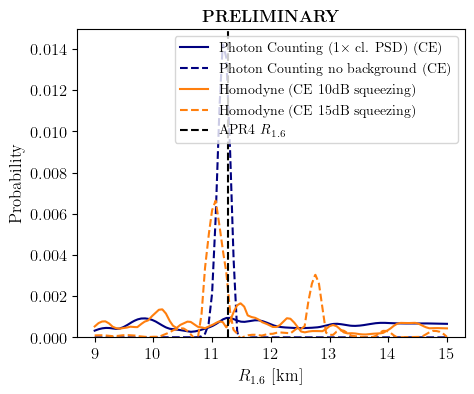

In [7]:
fig = plt.figure(figsize=(5,4))

from scipy.interpolate import interp1d

Rs = np.linspace(9,15,1000)

plt.plot(Rs, interp1d(R1d6s, prob_pc, kind='linear')(Rs), color="navy", label=r'Photon Counting ($1\times$ cl. PSD) (CE)')
plt.plot(Rs, interp1d(R1d6s, prob_pc_no_background, kind='linear')(Rs), color="navy", ls='--', label='Photon Counting no background (CE)')
plt.plot(Rs, interp1d(R1d6s, prob_strain, kind='linear')(Rs), color="C1", label='Homodyne (CE 10dB squeezing)')
plt.plot(Rs, interp1d(R1d6s, prob_strain_15db, kind='linear')(Rs), color="C1", label='Homodyne (CE 15dB squeezing)', ls='--')
#plt.plot(Rs, interp1d(R1d6s, prob_strain_15db, kind='linear')(Rs), color="C1", ls='--', label='Homodyne (CE 15dB squeezing)')

plt.axvline(11.27, color='k', label=r'APR4 $R_{1.6}$', linestyle='--')

#plt.ylim(0,0.4)
#plt.xlim(10.5,12.5)
plt.ylabel(r'Probability')
plt.xlabel(r'$R_{1.6}$ [km]')

plt.legend(loc='upper right', fontsize=10, frameon=True)

plt.title(r'\textbf{PRELIMINARY}')
plt.ylim(0,)
plt.savefig("hierarchical.png", bbox_inches='tight', dpi=300)

In [8]:
logl_pc = np.cumsum(loglikelihoods,axis=0)
logl_pc -= logsumexp(logl_pc, axis=1)[:,None]
logl_pc_cumul = cumlogsumexp(logl_pc, axis=1)
logl_pc_cumul -= np.max(logl_pc_cumul, axis=1)[:, None]

logl_pc_no_background = np.cumsum(loglikelihoods_no_background,axis=0)
logl_pc_no_background -= logsumexp(logl_pc_no_background, axis=1)[:,None]
logl_pc_no_background_cumul = cumlogsumexp(logl_pc_no_background, axis=1)
logl_pc_no_background_cumul -= np.max(logl_pc_no_background_cumul, axis=1)[:, None]

logl_strain = np.cumsum(loglikelihoods_strain,axis=0)
logl_strain -= logsumexp(logl_strain, axis=1)[:,None]
logl_strain_cumul = cumlogsumexp(logl_strain, axis=1)
logl_strain_cumul -= np.max(logl_strain_cumul, axis=1)[:,None]

logl_strain_15db = np.cumsum(loglikelihoods_strain_15db,axis=0)
logl_strain_15db -= logsumexp(logl_strain_15db, axis=1)[:,None]
logl_strain_15db_cumul = cumlogsumexp(logl_strain_15db, axis=1)
logl_strain_15db_cumul -= np.max(logl_strain_15db_cumul, axis=1)[:,None]

pc_r1d6_widths = []
pc_r1d6_widths_strain = []
pc_r1d6_widths_strain_15db = []
pc_r1d6_widths_no_background = []

for i in tqdm(range(Nevents)):
    bounds = interp1d(np.exp(logl_pc_cumul[i]), R1d6s, kind='linear', fill_value=(0,1), bounds_error=False)(np.array([0.16, 0.84]))
    width_pc = np.diff(bounds)[0]
    pc_r1d6_widths.append(width_pc)

    bounds = interp1d(np.exp(logl_pc_no_background_cumul[i]), R1d6s, kind='linear', fill_value=(0,1), bounds_error=False)(np.array([0.16, 0.84]))
    width_pc = np.diff(bounds)[0]
    pc_r1d6_widths_no_background.append(width_pc)

    bounds = interp1d(np.exp(logl_strain_cumul[i]), R1d6s, kind='linear', fill_value=(0,1), bounds_error=False)(np.array([0.16, 0.84]))
    width_pc = np.diff(bounds)[0]
    pc_r1d6_widths_strain.append(width_pc)

    bounds = interp1d(np.exp(logl_strain_15db_cumul[i]), R1d6s, kind='linear', fill_value=(0,1), bounds_error=False)(np.array([0.16, 0.84]))
    width_pc = np.diff(bounds)[0]
    pc_r1d6_widths_strain_15db.append(width_pc)


100%|██████████| 10000/10000 [00:30<00:00, 332.41it/s]


(0.0, 10000.0)

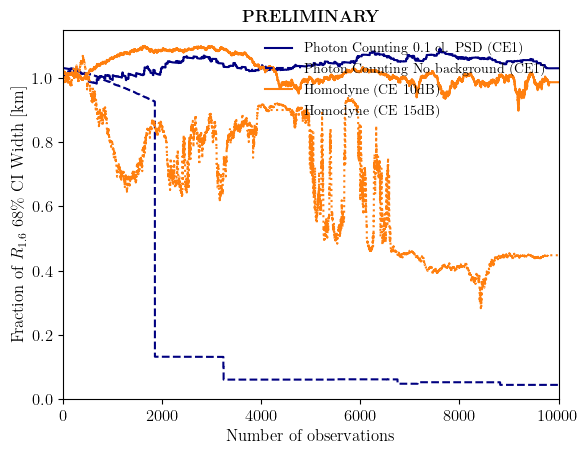

In [9]:
plt.step(np.linspace(0,Nevents,Nevents, dtype=int), np.array(pc_r1d6_widths)/(0.68 * (15-9)), color="navy", label='Photon Counting 0.1 cl. PSD (CE1)')
plt.step(np.linspace(0,Nevents,Nevents, dtype=int), np.array(pc_r1d6_widths_no_background)/4, color="navy", ls='--', label='Photon Counting No background (CE1)')
plt.step(np.linspace(0,Nevents,Nevents, dtype=int), np.array(pc_r1d6_widths_strain)/(0.68 * (15-9)), color="C1", label='Homodyne (CE 10dB)')
plt.step(np.linspace(0,Nevents,Nevents, dtype=int), np.array(pc_r1d6_widths_strain_15db)/(0.68 * (15-9)), color="C1", ls=':', label='Homodyne (CE 15dB)')

plt.ylabel(r'Fraction of $R_{1.6}$ 68\% CI Width [km]')
plt.xlabel(r'Number of observations')

#plt.plot(np.linspace(0,Nevents,Nevents, dtype=int), 2/np.sqrt(np.linspace(0,Nevents,Nevents, dtype=int)), color='k', ls='--', label=r'$\propto 1/\sqrt{N}$')
plt.legend(loc='upper right', fontsize=10, frameon=False)
plt.title(r'\textbf{PRELIMINARY}')

plt.ylim(0,1.15)
plt.xlim(0,Nevents)

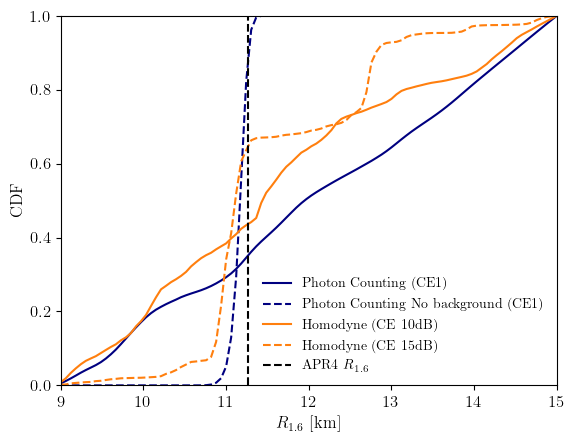

In [10]:
plt.plot(R1d6s, np.exp(logl_pc_cumul.T)[:,-1], label=r'Photon Counting (CE1)', color="navy")
plt.plot(R1d6s, np.exp(logl_pc_no_background_cumul.T)[:,-1], label='Photon Counting No background (CE1)', color="navy", ls='--')
plt.plot(R1d6s, np.exp(logl_strain_cumul.T)[:,-1], label='Homodyne (CE 10dB)', color="C1")
plt.plot(R1d6s, np.exp(logl_strain_15db_cumul.T)[:,-1], label='Homodyne (CE 15dB)', color="C1", ls='--')

plt.xlabel(r'$R_{1.6}$ [km]')
plt.ylabel(r'CDF')

plt.axvline(11.27, color='k', label=r'APR4 $R_{1.6}$', linestyle='--')
plt.legend(loc='lower right', fontsize=10, frameon=False)

plt.xlim(9,15)
plt.ylim(0,1.0)
plt.show()

In [3]:
dataset = np.genfromtxt(f'/home/ethan.payne/projects/GWPhotonCounting/projects/PM_EOS/hierarchical_EOS/bns_pm_dataset_MLE_250502_clean.dat')
dataset2 = np.genfromtxt(f'/home/ethan.payne/projects/GWPhotonCounting/projects/PM_EOS/hierarchical_EOS/bns_pm_dataset_MLE_250508.dat')


amplitude_samples = dataset[:, 9]
gamma_samples = dataset[:, 8]

amplitude_samples2 = dataset2[:, 9]
gamma_samples2 = dataset2[:, 8]

In [4]:
photon_generating_signals = dataset[np.argwhere(signal_photons > 0).flatten()]

NameError: name 'signal_photons' is not defined

In [5]:
np.argwhere(signal_photons > 0).flatten()

NameError: name 'signal_photons' is not defined

In [14]:
snrs_sqz = dataset[:,-1]

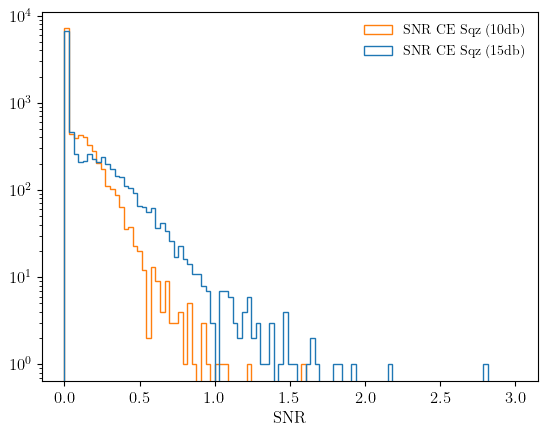

In [15]:
plt.hist(snrs_sqz, bins=np.linspace(0,3,100), histtype='step', color='C1', label='SNR CE Sqz (10db)')
plt.hist(np.sqrt(10**0.5)*snrs_sqz, bins=np.linspace(0,3,100), histtype='step', color='C0', label='SNR CE Sqz (15db)')

plt.yscale('log')
plt.xlabel(r'SNR')


plt.legend(loc='upper right', fontsize=10, frameon=False)

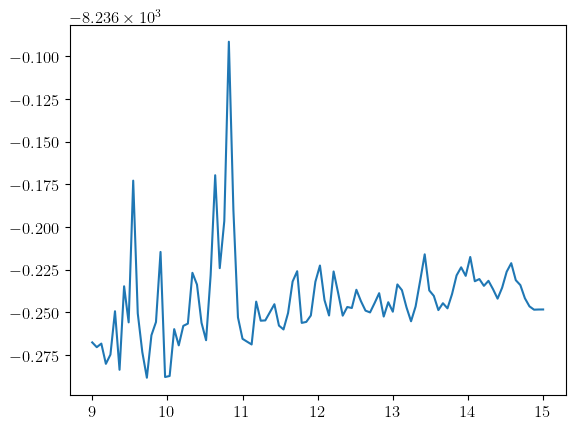

In [16]:
plt.plot(R1d6s, loglikelihoods_strain_15db[np.argmax(snrs_silica)])

In [6]:
import GWPhotonCounting
import jax.numpy as jnp
import jax
import numpy as np
import bilby
from bilby_cython.geometry import frequency_dependent_detector_tensor

import json
import sys
import os

from astropy.cosmology import Planck18
import astropy.units as u

# injected snr
idx = 5

from tqdm import tqdm

import jax
jax.config.update("jax_enable_x64", True)

frequencies = jnp.sort(jnp.fft.fftfreq(2**13, d=1/1e4))

# Setting up the two detectors to compare the 
detector_nosqz = GWPhotonCounting.detector.Detector(
    frequencies, '/home/ethan.payne/projects/GWPhotonCounting/examples/data/CE_shot_psd_nosqz.csv', 
    '/home/ethan.payne/projects/GWPhotonCounting/examples/data/CE_classical_psd.csv', 
    gamma=100, random_seed=1632, N_frequency_spaces=10)

detector_sqz = GWPhotonCounting.detector.Detector(
    frequencies, '/home/ethan.payne/projects/GWPhotonCounting/examples/data/CE_total_psd_sqz.csv', None, 
    gamma=100, random_seed=1632, N_frequency_spaces=10)

#Loading in the individual analysis from the sample
KNNModel = GWPhotonCounting.signal.PostMergerKNN(knn_file_path='/home/ethan.payne/code_libraries/apr4_knn_gw_model_2024/KNN_Models/APR4-knn_model-N100')
LorentzianModel = GWPhotonCounting.signal.PostMergerLorentzian()
dataset = np.genfromtxt(f'/home/ethan.payne/projects/GWPhotonCounting/projects/PM_EOS/hierarchical_EOS/bns_pm_dataset_MLE_250502_clean.dat')

mtots, z, phi, psi, ra, dec, iota, f0_fit, gamma_fit, A_fit, phase_fit, snr, snr_sqz = dataset[idx]
print('SNRs are: ', snr, snr_sqz)

amplitude_samples = dataset[:, 9] * A_fit/np.median(dataset[:,9])#* Planck18.luminosity_distance( dataset[:,1]).value / Planck18.luminosity_distance(z).value
gamma_samples = dataset[:, 8]

# Compute the expected number of photons and the strain
PM_strain = KNNModel.generate_strain(detector_nosqz, frequencies, mtots, phi, z, ra, dec, iota, psi)

# # What I'm doing here is generating a Lorentzian signal with the same amplitude as the KNN model
# # I'm using this as a replacemenet/test because then the amplitude of the signal that we recover with and inject with is the same!  
# PM_strain = LorentzianModel.generate_strain(
#     detector_nosqz, frequencies, f0=f0_fit, gamma=gamma_fit, A=A_fit, phase=0, t0=0)[0]

# if detector_nosqz.calculate_optimal_snr(PM_strain, frequencies) > snr:
#     A = A_fit* snr / detector_nosqz.calculate_optimal_snr(PM_strain, frequencies)

#     PM_strain = LorentzianModel.generate_strain(
#         detector_nosqz, frequencies, f0=f0_fit, gamma=gamma_fit, A=A, phase=0, t0=0)[0]


# print(A_fit, detector_nosqz.calculate_optimal_snr(PM_strain, frequencies), snr)

# Getting the frequencies
R1d6s = np.linspace(9,15,100) # 25
f0_R1d6s = GWPhotonCounting.hierarchical.frequency_model(mtots, R1d6s)/(1+z)

# Setting up the likelihood
poisson_likelihood = GWPhotonCounting.distributions.PoissonPhotonLikelihood()
noise_likelihood = GWPhotonCounting.distributions.PhaseQuadraturePhotonLikelihood() 
gaussian_likelihood = GWPhotonCounting.distributions.GaussianStrainLikelihood()
convolved_likelihood = GWPhotonCounting.distributions.MixturePhotonLikelihood(poisson_likelihood, noise_likelihood)

# Marginalizing over the likelihood
N_samples = 100
N_t0s = 10


# Calculation for the CE1 detector
observed_photons, signal_photons, noise_photons = convolved_likelihood.generate_realization(
        detector_nosqz.calculate_signal_photon_expectation(PM_strain, frequencies), 
        detector_nosqz.noise_photon_expectation)
_, _, noise_photons_0d01 = convolved_likelihood.generate_realization(
        detector_nosqz.calculate_signal_photon_expectation(PM_strain, frequencies),
        0.01 * detector_nosqz.noise_photon_expectation)
_, _, noise_photons_0d1 = convolved_likelihood.generate_realization(
        detector_nosqz.calculate_signal_photon_expectation(PM_strain, frequencies),
        0.1 * detector_nosqz.noise_photon_expectation)
_, _, noise_photons_0d5 = convolved_likelihood.generate_realization(
        detector_nosqz.calculate_signal_photon_expectation(PM_strain, frequencies),
        0.5 * detector_nosqz.noise_photon_expectation)
observed_photons_no_background = signal_photons
observed_strain = PM_strain + gaussian_likelihood.generate_realization(detector_sqz.total_psd, frequencies)
observed_strain_15db = PM_strain + gaussian_likelihood.generate_realization(10**(-0.5) * detector_sqz.total_psd, frequencies)
observed_strain_20db = PM_strain + gaussian_likelihood.generate_realization(10**(-1) * detector_sqz.total_psd, frequencies)

likelihood_event_i = np.zeros(len(f0_R1d6s))
likelihood_event_i_0d01 = np.zeros(len(f0_R1d6s))
likelihood_event_i_0d1 = np.zeros(len(f0_R1d6s))
likelihood_event_i_0d5 = np.zeros(len(f0_R1d6s))
likelihood_event_i_no_background = np.zeros(len(f0_R1d6s))
likelihood_event_i_strain = np.zeros(len(f0_R1d6s))
likelihood_event_i_strain_15db = np.zeros(len(f0_R1d6s))
likelihood_event_i_strain_20db = np.zeros(len(f0_R1d6s))

t0s = jnp.linspace(-0.02, 0.02, N_t0s)
sample_indexes = np.random.choice(10000, size=N_samples, replace=False)
print(gamma_fit, A_fit, f0_fit)

phi0s = np.random.uniform(0, 2*np.pi, N_samples)

for l, f0 in tqdm(enumerate(f0_R1d6s), total=len(f0_R1d6s)):

    likelihood_array_i = np.zeros(N_samples)
    likelihood_array_i_0d01 = np.zeros(N_samples)
    likelihood_array_i_0d1 = np.zeros(N_samples)
    likelihood_array_i_0d5 = np.zeros(N_samples)
    likelihood_array_i_no_background = np.zeros(N_samples)
    likelihood_array_i_strain = np.zeros(N_samples)
    likelihood_array_i_strain_15db = np.zeros(N_samples)
    likelihood_array_i_strain_20db = np.zeros(N_samples)

    for j in range(N_samples):

        expected_photon_count_signal = LorentzianModel.generate_photon_count(
            detector_nosqz, frequencies, f0=f0, gamma=gamma_samples[sample_indexes[j]], A=amplitude_samples[sample_indexes[j]],
            phase=phi0s[j], t0=t0s)
        expected_strain = LorentzianModel.generate_strain(
            detector_nosqz, frequencies, f0=f0, gamma=gamma_samples[sample_indexes[j]], A=amplitude_samples[sample_indexes[j]],
            phase=phi0s[j], t0=t0s)
        
        
        # likelihood_array_i[j] = convolved_likelihood(
        #     signal_photons+noise_photons, expected_photon_count_signal, detector_nosqz.noise_photon_expectation)
        # likelihood_array_i_0d01[j] = convolved_likelihood(
        #     signal_photons+noise_photons_0d01, expected_photon_count_signal, 0.01 * detector_nosqz.noise_photon_expectation)
        # likelihood_array_i_0d1[j] = convolved_likelihood(
        #     signal_photons+noise_photons_0d1, expected_photon_count_signal, 0.1 * detector_nosqz.noise_photon_expectation)
        # likelihood_array_i_0d5[j] = convolved_likelihood(
        #     signal_photons+noise_photons_0d5, expected_photon_count_signal, 0.5 * detector_nosqz.noise_photon_expectation)
        # likelihood_array_i_no_background[j] = poisson_likelihood(
        #     observed_photons_no_background, expected_photon_count_signal)
    
        likelihood_array_i_strain[j] = gaussian_likelihood(observed_strain, expected_strain, detector_sqz.total_psd, frequencies)
        likelihood_array_i_strain_15db[j] = gaussian_likelihood(observed_strain_15db, expected_strain, 10**(-0.5) * detector_sqz.total_psd, frequencies)
        likelihood_array_i_strain_20db[j] = gaussian_likelihood(observed_strain_20db, expected_strain, 10**(-1) * detector_sqz.total_psd, frequencies)

    # likelihood_event_i[l] = jax.scipy.special.logsumexp(likelihood_array_i) - jnp.log(len(likelihood_array_i))
    # likelihood_event_i_0d01[l] = jax.scipy.special.logsumexp(likelihood_array_i_0d01) - jnp.log(len(likelihood_array_i_0d01))
    # likelihood_event_i_0d1[l] = jax.scipy.special.logsumexp(likelihood_array_i_0d1) - jnp.log(len(likelihood_array_i_0d1))
    # likelihood_event_i_0d5[l] = jax.scipy.special.logsumexp(likelihood_array_i_0d5) - jnp.log(len(likelihood_array_i_0d5))
    # likelihood_event_i_no_background[l] = jax.scipy.special.logsumexp(likelihood_array_i_no_background) - jnp.log(len(likelihood_array_i_no_background))
    likelihood_event_i_strain[l] = jax.scipy.special.logsumexp(likelihood_array_i_strain) - jnp.log(len(likelihood_array_i_strain))
    likelihood_event_i_strain_15db[l] = jax.scipy.special.logsumexp(likelihood_array_i_strain_15db) - jnp.log(len(likelihood_array_i_strain_15db))
    likelihood_event_i_strain_20db[l] = jax.scipy.special.logsumexp(likelihood_array_i_strain_20db) - jnp.log(len(likelihood_array_i_strain_20db))

/home/ethan.payne/.conda/envs/ve310/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsRegressor from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


SNRs are:  0.03822400149176862 0.09051704345791092
27.951833145379158 5.72786613398794e-24 1462.09299353437


100%|██████████| 100/100 [02:46<00:00,  1.67s/it]


In [7]:
detector_sqz.calculate_optimal_snr(PM_strain, frequencies, fmin=100, fmax=4e3)

Array(0.39628608, dtype=float64)

In [8]:
likelihood_event_i_strain

array([-2053.79564656, -2053.76311669, -2053.81422245, -2053.78417523,
       -2053.82535123, -2053.82721193, -2053.80066436, -2053.8359027 ,
       -2053.83044881, -2053.79738736, -2053.8034331 , -2053.79411985,
       -2053.7717065 , -2053.76975446, -2053.74719435, -2053.70160967,
       -2053.66876023, -2053.56601757, -2053.66206693, -2053.79030024,
       -2053.77331506, -2053.71162955, -2053.74303397, -2053.70723954,
       -2053.76983667, -2053.79567334, -2053.84627815, -2053.84045756,
       -2053.83818637, -2053.77063855, -2053.69545314, -2053.77245911,
       -2053.8120589 , -2053.78650653, -2053.74219735, -2053.77674492,
       -2053.74793856, -2053.76829199, -2053.79660267, -2053.79794032,
       -2053.79459068, -2053.82315969, -2053.79765171, -2053.73100812,
       -2053.6696678 , -2053.71814308, -2053.74402172, -2053.6900372 ,
       -2053.7114262 , -2053.7019316 , -2053.77006592, -2053.76755412,
       -2053.74254057, -2053.82019388, -2053.85499431, -2053.84273401,
      

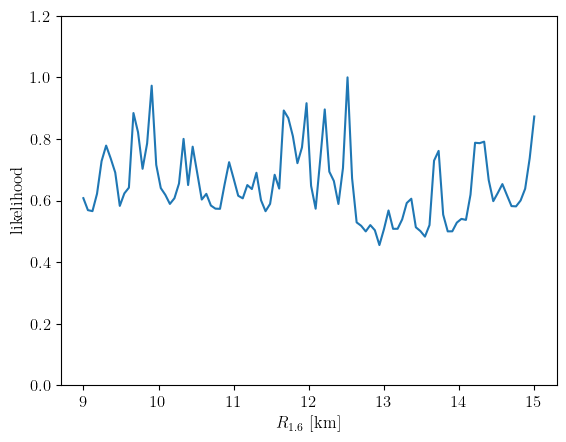

In [10]:
plt.plot(R1d6s,  np.exp(likelihood_event_i_strain_20db - np.max(likelihood_event_i_strain_20db)))

plt.xlabel(r'$R_{1.6}$ [km]')
plt.ylabel(r'likelihood')

plt.ylim(0,1.2)

plt.show()

In [21]:
import GWPhotonCounting
import jax.numpy as jnp
import numpy as np
import bilby
import jaxopt

from corner import corner
import matplotlib.pyplot as plt
from tqdm import tqdm

from astropy.cosmology import Planck18
import astropy.units as u

from scipy.optimize import minimize

import jax
jax.config.update("jax_enable_x64", True)

frequencies = jnp.sort(jnp.fft.fftfreq(2**13, d=1/1e4))

# Setting up the two detectors to compare the 
detector_nosqz = GWPhotonCounting.detector.Detector(
    frequencies, '/home/ethan.payne/projects/GWPhotonCounting/examples/data/CE_shot_psd_nosqz.csv', 
    '/home/ethan.payne/projects/GWPhotonCounting/examples/data/CE_classical_psd.csv', 
    gamma=100, random_seed=1632, N_frequency_spaces=10)

detector_sqz = GWPhotonCounting.detector.Detector(
    frequencies, '/home/ethan.payne/projects/GWPhotonCounting/examples/data/CE_total_psd_sqz.csv', None, 
    gamma=100, random_seed=1632, N_frequency_spaces=10)

zmax = 10
zinterp = np.expm1(np.linspace(np.log1p(0), np.log1p(zmax), 2000))
dVdzdt_interp = 4*np.pi*Planck18.differential_comoving_volume(zinterp).to(u.Gpc**3/u.sr).value/(1+zinterp)

KNNModel = GWPhotonCounting.signal.PostMergerKNN(knn_file_path='/home/ethan.payne/code_libraries/apr4_knn_gw_model_2024/KNN_Models/APR4-knn_model-N100')
LorentzianModel = GWPhotonCounting.signal.PostMergerLorentzian()

gaussian_likelihood = GWPhotonCounting.distributions.GaussianStrainLikelihood()

def sample_redshift(n):
    pdf_red = ((1+zinterp)**2.7)/(1+((1+zinterp)/2.9)**5.6) * dVdzdt_interp
    cum_sum_red = np.cumsum(pdf_red)/np.sum(pdf_red)
    
    return np.interp(np.random.uniform(size=n), cum_sum_red, zinterp)

def neg_logl_cost_function(x0, strain, frequencies):

    f0, gamma, log10A, phase = x0

    t0s = jnp.linspace(-0.02, 0.02, 10)

    # Calculate the expected strain
    lorentzian_strain = LorentzianModel.generate_strain(
        detector_nosqz, frequencies, f0=f0, gamma=gamma, A=10**log10A, phase=phase, t0=t0s)

    # Calculate the log-likelihood
    logl = gaussian_likelihood(strain, lorentzian_strain, jnp.ones(len(frequencies))*1e-60,frequencies)

    # Return the negative logl
    return -logl


# Adding samples to the dataset
bns_pm_dataset = []

for N in tqdm(range(int(1))):
    m1 = bilby.gw.prior.Uniform(1.2,1.4).sample(1)[0]
    m2 = bilby.gw.prior.Uniform(1.2,1.4).sample(1)[0]
    mtots = m1+m2

    z = sample_redshift(1)[0]

    phi = bilby.gw.prior.Uniform(0,2*np.pi).sample(1)[0]
    psi = bilby.gw.prior.Uniform(0,np.pi).sample(1)[0]

    ra = bilby.core.prior.Uniform(0,2*np.pi).sample(1)[0]
    dec = bilby.core.prior.Cosine().sample(1)[0]

    iota = bilby.core.prior.Sine().sample(1)[0]
    
    PM_strain = KNNModel.generate_strain(detector_nosqz, frequencies, mtots, phi, z, ra, dec, iota, psi)

    params_0 = [np.abs(frequencies[np.argmax(np.abs(PM_strain))]), np.random.uniform(0,50), jnp.log10(np.max(np.abs(PM_strain))), np.random.uniform(0,2*np.pi)]

    minimize_result = minimize(neg_logl_cost_function, 
                                x0=params_0,
                                args=(PM_strain, frequencies),
                                bounds=[(500, 4e3), (1e-5, 400), (-50, -19), (0, 2*np.pi)])
    
    f0_fit, gamma_fit, log10A_fit, phase_fit = minimize_result.x

    solver = jaxopt.LBFGS(fun=neg_logl_cost_function, maxiter=1000)
    res = solver.run(jnp.array(params_0), strain=PM_strain, frequencies=frequencies)
    f0_fit2, gamma_fit2, log10A_fit2, phase_fit2 = res.params

    if gamma_fit2 < 0:
        gamma_fit2 = np.abs(gamma_fit2)
        phase_fit2 += np.pi
        phase_fit2 = phase_fit2 % (2*np.pi)


    snr_CE = detector_nosqz.calculate_optimal_snr(PM_strain, frequencies)
    SNR_CEsilica = detector_sqz.calculate_optimal_snr(PM_strain, frequencies)

    print(f0_fit, gamma_fit, log10A_fit, phase_fit, SNR_CEsilica, snr_CE)
    print(f0_fit2, gamma_fit2, log10A_fit2, phase_fit2, SNR_CEsilica, snr_CE)

/home/ethan.payne/.conda/envs/ve310/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsRegressor from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
100%|██████████| 1/1 [00:15<00:00, 15.25s/it]

1892.90454630572 10.411850327271003 -23.609525212985858 3.002249825464205 0.37263305497075006 0.15638567077032225
1892.5277897574592 5.048002073112531 -23.901897474839696 1.7826901609138337 0.37263305497075006 0.15638567077032225


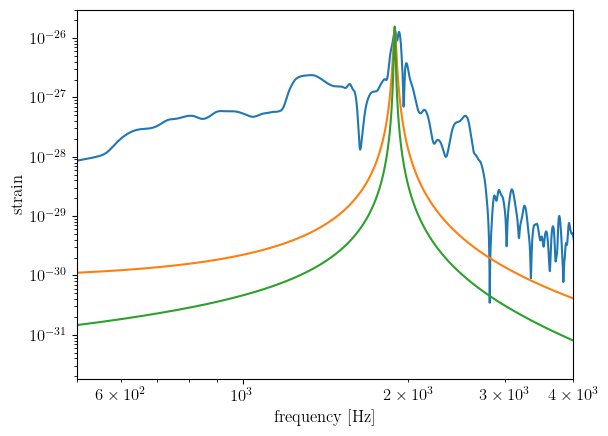

In [22]:
plt.loglog(frequencies,  np.abs(PM_strain))

PM_strain_lor = LorentzianModel.generate_strain(
    detector_nosqz, frequencies, f0=f0_fit, gamma=gamma_fit, A=10**log10A_fit, phase=phase_fit, t0=0)[0]
PM_strain_lor2 = LorentzianModel.generate_strain(
    detector_nosqz, frequencies, f0=f0_fit2, gamma=gamma_fit2, A=10**log10A_fit2, phase=phase_fit2, t0=0)[0]
plt.loglog(frequencies,  np.abs(PM_strain_lor))
plt.loglog(frequencies,  np.abs(PM_strain_lor2))

plt.xlabel(r'frequency [Hz]')
plt.ylabel(r'strain')
plt.xlim(500,4000)
plt.show()

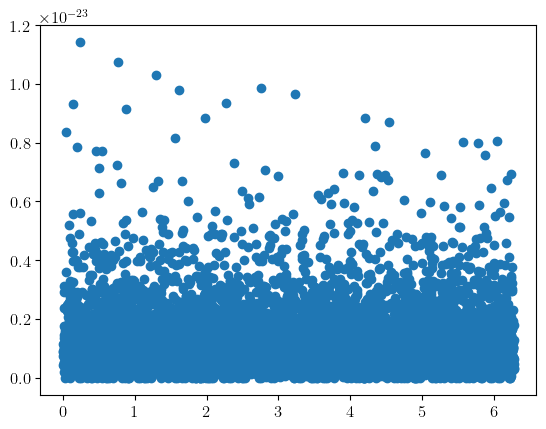

In [23]:
plt.scatter(dataset2[:,-3] % (2 * np.pi), dataset2[:,-4])

(array([452., 422., 465., 459., 436., 427., 462., 451., 437., 454., 442.,
        423., 449., 413., 422., 406., 423., 465., 414., 462., 466., 446.,
        441., 427., 436.]),
 array([7.92688390e-04, 2.52076730e-01, 5.03360772e-01, 7.54644813e-01,
        1.00592885e+00, 1.25721290e+00, 1.50849694e+00, 1.75978098e+00,
        2.01106502e+00, 2.26234906e+00, 2.51363310e+00, 2.76491715e+00,
        3.01620119e+00, 3.26748523e+00, 3.51876927e+00, 3.77005331e+00,
        4.02133735e+00, 4.27262140e+00, 4.52390544e+00, 4.77518948e+00,
        5.02647352e+00, 5.27775756e+00, 5.52904160e+00, 5.78032565e+00,
        6.03160969e+00, 6.28289373e+00]),
 <BarContainer object of 25 artists>)

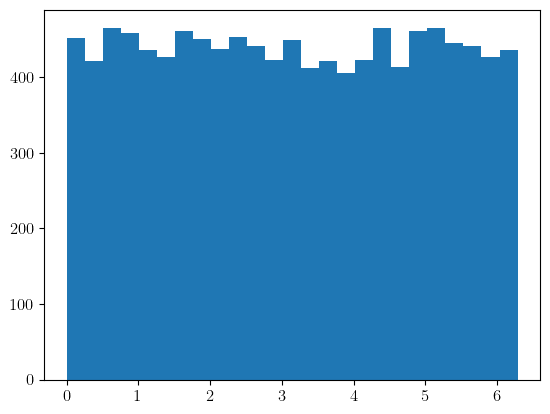

In [24]:
plt.hist(dataset2[:,-3] % (2 * np.pi), bins=25)


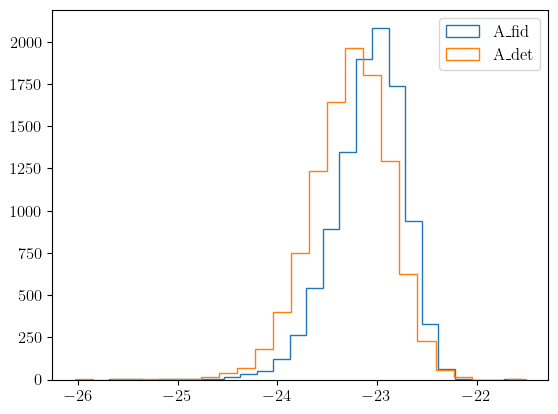

In [25]:
from astropy.cosmology import Planck18


plt.hist(np.log10(amplitude_samples * Planck18.luminosity_distance(dataset[:,1]).value/Planck18.luminosity_distance(dataset[10,1]).value), 
         bins=25, label='A_fid', histtype='step')
plt.hist(np.log10(amplitude_samples), bins=25, label='A_det', histtype='step')
plt.legend()

In [26]:
dataset[10,-1]

0.17505846184102933

(array([  1.,   0.,   3.,   0.,   1.,   1.,   1.,   2.,   3.,   2.,   2.,
          0.,   7.,   8.,  13.,  15.,  17.,  15.,  27.,  34.,  36.,  40.,
         55.,  69.,  74.,  93., 128., 137., 151., 156., 185., 198., 180.,
        224., 238., 220., 225., 222., 216., 209., 190., 166., 161., 138.,
        121., 124., 136., 149., 156., 164., 198., 175., 182., 240., 225.,
        235., 216., 208., 224., 176., 181., 131., 143., 130.,  90.,  72.,
         90.,  66.,  85.,  72.,  84.,  84., 109., 131., 123., 130., 161.,
        201., 208., 226., 247., 278., 234., 224., 196., 151., 129.,  86.,
         60.,  41.,  22.,  14.,   3.,   4.,   1.,   0.,   0.,   0.,   0.,
          1.]),
 array([-5.43269588, -5.37506673, -5.31743758, -5.25980843, -5.20217928,
        -5.14455012, -5.08692097, -5.02929182, -4.97166267, -4.91403352,
        -4.85640437, -4.79877522, -4.74114607, -4.68351692, -4.62588776,
        -4.56825861, -4.51062946, -4.45300031, -4.39537116, -4.33774201,
        -4.28011286, -4.22

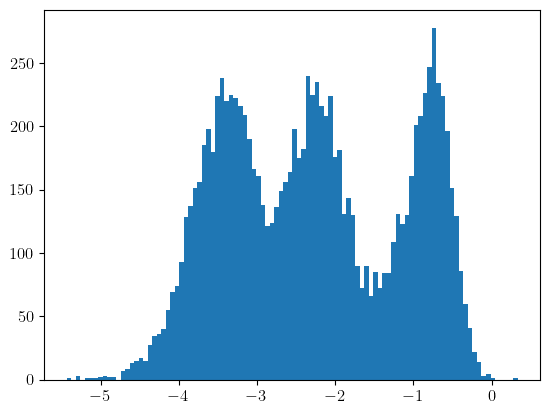

In [27]:
plt.hist(np.log10(dataset2[:,-1]), bins=100)

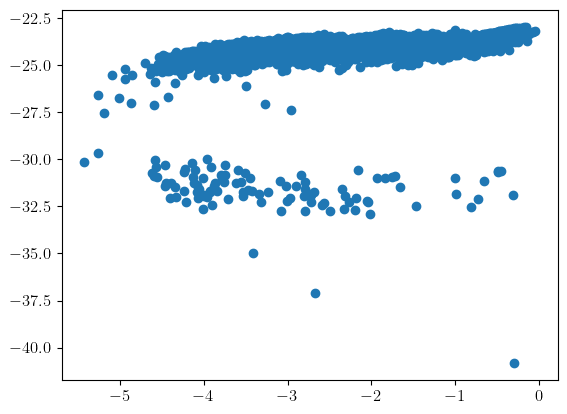

In [28]:
plt.scatter(np.log10(dataset2[:,-1]), np.log10(amplitude_samples2))

In [29]:
np.sum(amplitude_samples2 < 1e-29)

103